### Construct simulation network

In [1]:
### import packages 
from brian2 import *
from brian2.units import *
from brian2 import ms
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
import json

### Striatum - GPe - STN - Cortex

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       The synaptic equation for the variable s_AMPA_ext does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
WARNING    'u' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([], shape=(30, 0), dtype=float64) * amp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value array([], shape=(30, 0), dty

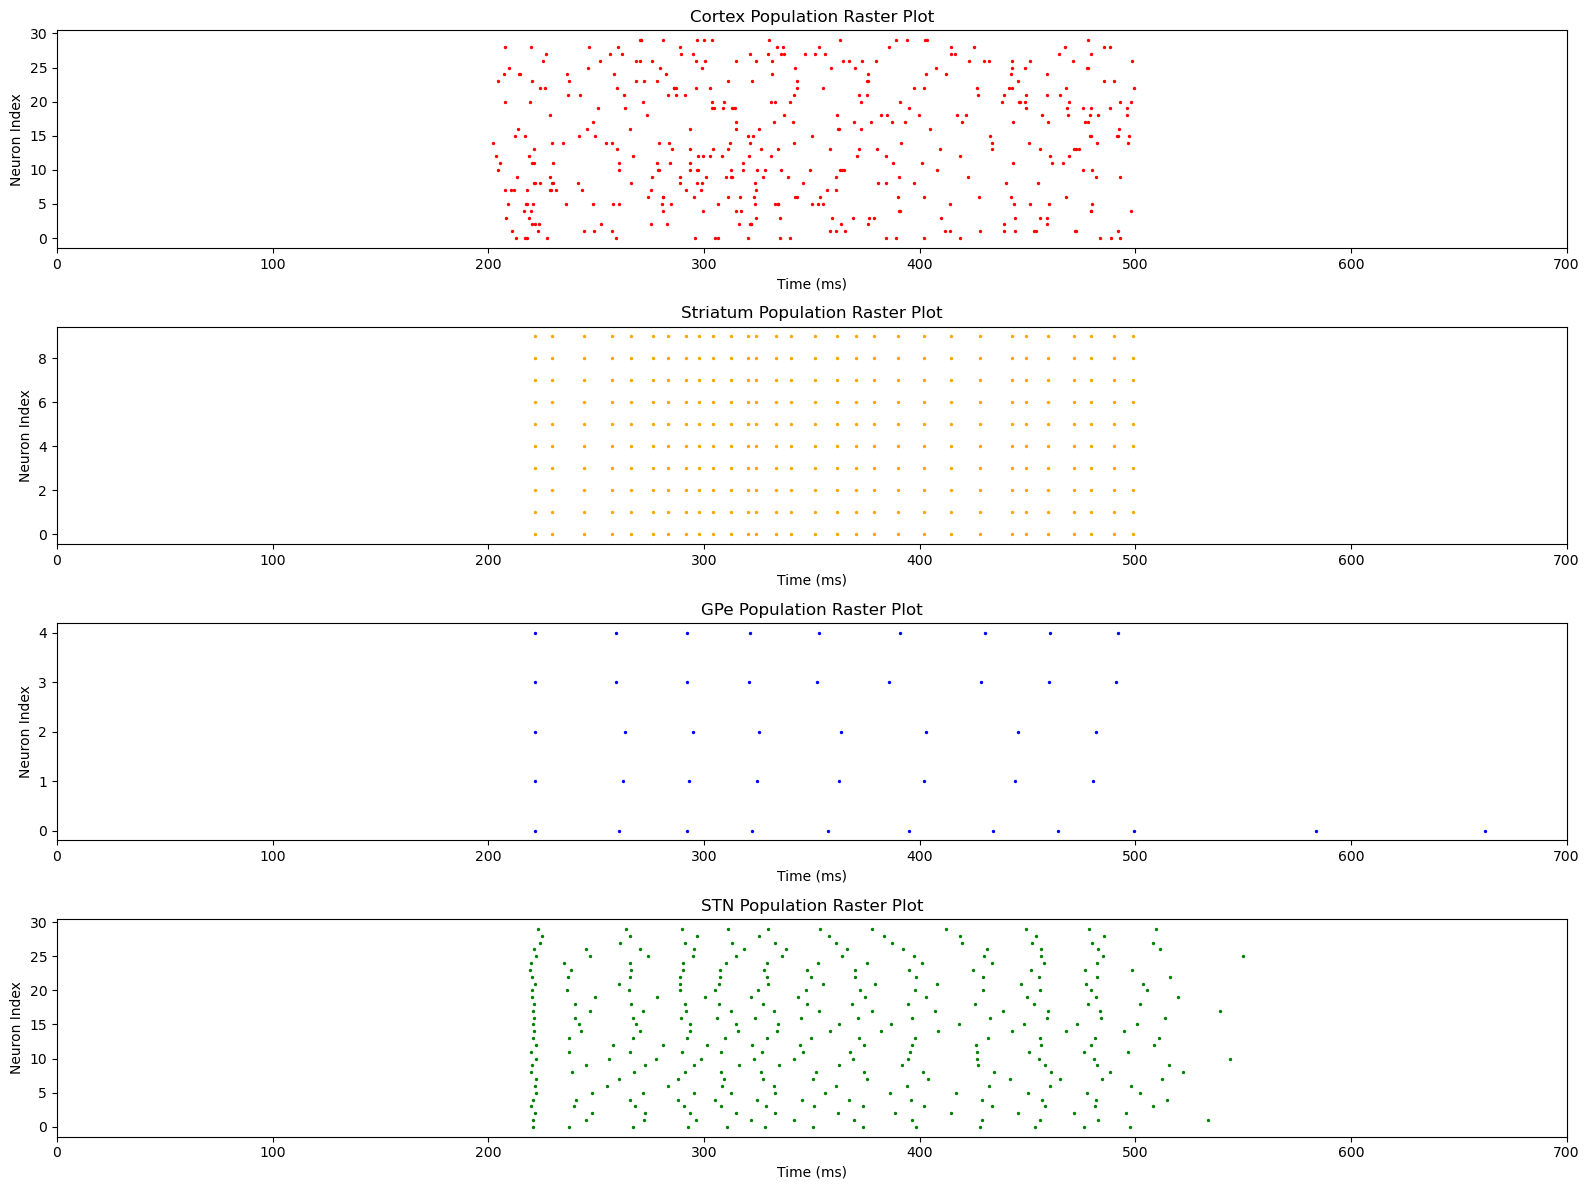

In [1]:
### Result with inh/ext input with only one neuron 
from simulation_runner_syn import run_simulation_with_inh_ext_input, plot_results_pre_post, plot_raster, plot_results_I
from brian2 import *

gpe_params_file = './params_ref/GPe_T1_1.json'
stn_params_file = './params_ref/STN_1.json'
striatum_params_file = './params_ref/MSN_D2_1.json'  # 추가: Striatum 파라미터 파일

synapse_params = {
    # STN - GPe (ext)
    'g0_n': 0.08*nS,
    'nmda_tau_syn': 100*ms,  
    'nmda_E_rev': 0*mV,
    'g0_a': 0.35*nS,
    'ampa_tau_syn': 12*ms,  
    'ampa_E_rev': 0*mV,
    
    # EXT - GPe
    'g0_g': 0.04*nS,
    'gaba_tau_syn': 87 * ms,
    'gaba_E_rev': -74* mV,
    
    # Cortex - EXT
    'cs_g0_n': 0.11 * nS,
    'cs_g0_a': 0.5 * nS,
    'cs_ampa_tau_syn': 12 * ms,
    'cs_nmda_tau_syn': 160 * ms,
    'cs_ampa_E_rev': 0 * mV,
    'cs_nmda_E_rev': 0 * mV,
    
    # Cortex - STN (excitatory connection)
    'csn_g0_n': 0.00625 * nS,
    'csn_g0_a': 0.25 * nS,
    'csn_ampa_tau_syn': 4 * ms,
    'csn_nmda_tau_syn': 160 * ms,
    'csn_ampa_E_rev': 0 * mV,
    'csn_nmda_E_rev': 0 * mV,
    
    # GPe - STN
    'gsn_g0_g': 0.08*nS,
    'gsn_gaba_tau_syn': 8 * ms,
    'gsn_gaba_E_rev': -84 * mV
}

N_GPe = 5
N_STN = 30
N_Striatum = 10

results = run_simulation_with_inh_ext_input(
    N_GPe,
    N_STN,
    N_Striatum,
    gpe_params_file,
    stn_params_file,
    striatum_params_file,
    synapse_params,
    'GPe', 
    'STN', 
    'Striatum',
    "GPe_STN_inh_ext"
)

plot_raster(results)

WARNING    /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/ipykernel_74600/1819598510.py:42: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle='->', arrowsize=15, width=2)
 [py.warnings]


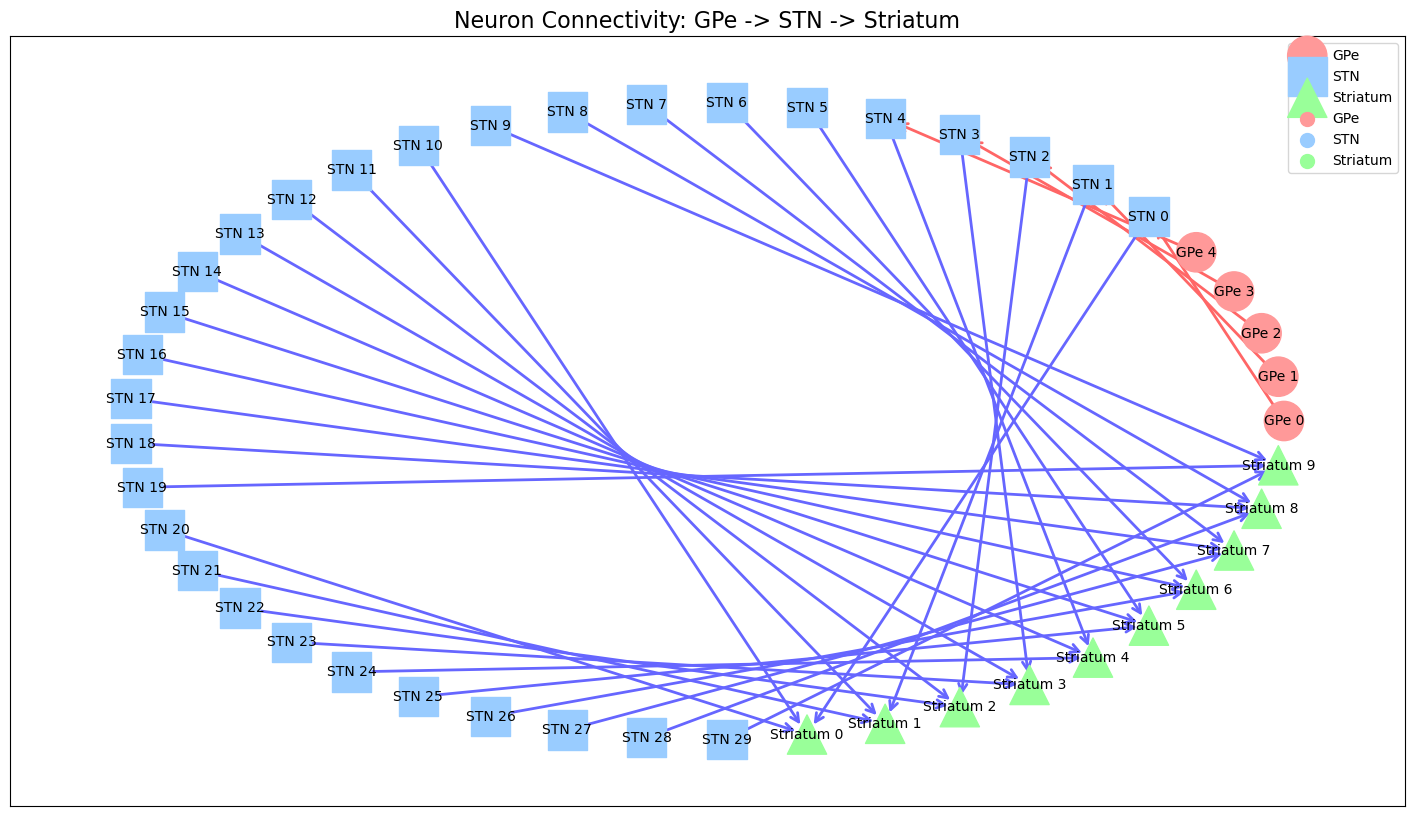

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_neuron_connections(results, N_GPe, N_STN, N_Striatum):
    # Create a directed graph
    plt.figure(figsize=(18, 10))

    G = nx.DiGraph()

    # Add nodes for each neuron group
    G.add_nodes_from(range(N_GPe), group='GPe')
    G.add_nodes_from(range(N_GPe, N_GPe + N_STN), group='STN')
    G.add_nodes_from(range(N_GPe + N_STN, N_GPe + N_STN + N_Striatum), group='Striatum')

    # Add edges (customize based on actual synapse connections)
    for i in range(N_GPe):
        G.add_edge(i, N_GPe + (i % N_STN))  # GPe to STN
    for i in range(N_STN):
        G.add_edge(N_GPe + i, N_GPe + N_STN + (i % N_Striatum))  # STN to Striatum

    # Circular layout to reduce overlap and improve aesthetics
    pos = nx.circular_layout(G)

    # Define node colors for different groups
    node_colors = ['#FF9999'] * N_GPe + ['#99CCFF'] * N_STN + ['#99FF99'] * N_Striatum

    # Define node shapes (can be customized for different neuron groups)
    node_shapes = {
        'GPe': 'o',  # Circle
        'STN': 's',  # Square
        'Striatum': '^'  # Triangle
    }

    # Draw nodes with different colors and shapes
    for group, shape in node_shapes.items():
        group_indices = [n for n, d in G.nodes(data=True) if d['group'] == group]
        nx.draw_networkx_nodes(G, pos, nodelist=group_indices, node_color=[node_colors[i] for i in group_indices],
                               node_size=800, node_shape=shape, label=group)

    # Draw edges with different colors for connections between neuron groups
    edge_colors = ['#FF6666' if G.nodes[u]['group'] == 'GPe' else '#6666FF' for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrowstyle='->', arrowsize=15, width=2)

    # Add labels
    labels = {i: f"GPe {i}" if i < N_GPe else f"STN {i - N_GPe}" if i < N_GPe + N_STN else f"Striatum {i - N_GPe - N_STN}" for i in range(N_GPe + N_STN + N_Striatum)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

    # Create a legend
    legend_labels = ['GPe', 'STN', 'Striatum']
    legend_colors = ['#FF9999', '#99CCFF', '#99FF99']
    for label, color in zip(legend_labels, legend_colors):
        plt.scatter([], [], c=color, label=label, s=100)
    plt.legend(loc='best')

    # Display the graph
    plt.title('Neuron Connectivity: GPe -> STN -> Striatum', fontsize=16)
    plt.gca().set_facecolor('white')  # Set background color
    plt.show()

# Example usage
plot_neuron_connections(results, N_GPe, N_STN, N_Striatum)

In [ ]:
# vis (firing rate): https://kordinglab.com/spykes/auto_examples/plot_neuropop_simul_example.html#simulate-a-population-of-neurons